# Self-Driving Car Engineer Nanodegree

## Advanced Lane Detection 

## Project: Build an advanced lane finding algorithm


# 1. Camera Caliberation

In [1]:
import numpy as np 

# for camera caliberation
import cv2

# for opening files
import os, sys

# for copying image and save them to disk 
import matplotlib.image as mpimg

# randint 
import random
# Plotting images 
import matplotlib.pyplot as plt 

### Define Camera Calibrator class
This project has a object oriented approach towards solving the goal of find lanes in driving videos. CameraCaliberator is the first class which is defined below which inputs the source of images used for caliberation and contains details of the caliberated camera e.g. distortion matrix, radial vector etc

In [2]:
# Camera Caliberator class 
class CameraCalibrator:
    ''' Constructor
    # Input args:
    ## test_images_folder - input folder where all the images required for camera calibration are present
    ## output_folder - where the undistorted images will be output
    ## number_of_corners - corners in the checkboard which need to be used for calibration
    '''
    def __init__(self, test_images_folder, number_of_corners=(8,6)):
        # root_folder containing path to input images folder 
        self.root_folder = test_images_folder
        
        # nx - number of corners in x dimension
        self.nx = number_of_corners[0]
        
        # ny - number of corners in y dimension
        self.ny = number_of_corners[1]
        
        # member variable to store 2-D image points 
        self.image_points = []
        
        # member variable to store 3-D real world object points
        self.object_points = []
        
        # image_shape - shape of the input images
        self.image_shape = None
        
        # member variable to store CameraMatrix 
        self.CameraMatrix = []
        
        # member variable to store DistortionMatrix
        self.DistortionMatrix = []

    ''' computeObjectPoints
    1. This method uses nx and ny to compute default set of real-world object points
    2. Returns object_points
    '''
    def computeObjectPoints(self):
        # Compute default set of object points 
        object_points = np.zeros((self.ny*self.nx, 3), np.float32)

        # reshape object points to x,y coordinates 
        object_points[:,:2] = np.mgrid[0:self.nx, 0:self.ny].T.reshape(-1, 2)
        
        return object_points 
    ''' findChessboardCorners
    # Input args
    # object_points - used in finding chessboard corners of distorted images 
    1 For each image in input folder
    1.1 Applies opencv algorithm "findChessboardCorners" to find the chessboard corners of the gray scale image using (nx, ny)
    1.2 Draws the corners on the gray image and prints a sample image 
    2. Stashes away object points and image points in object member variables
    '''
    def findChessboardCorners(self, object_points):
        # Loop through all images in the root_folders
        idx = 0
        
        # get all the images from root_folder 
        file_list = os.listdir(self.root_folder)
        
        # get the total number of images in the folder 
        self.number_of_images = len(file_list)
        
        # generate a random image index which is used for visualizing the chessboard corners 
        random_image_idx = random.randint(0, len(file_list)-1)
        
        for file in file_list:
            # read image
            image = cv2.imread(self.root_folder+"/"+ file)

            # convert image to grayscale 
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            if self.image_shape is None:
                self.image_shape = gray.shape[::-1]

            # use gray scale image to find chess board corners 
            ret, corners = cv2.findChessboardCorners(gray, (self.nx,self.ny), None)

            if corners is not None and corners.shape[0] == object_points.shape[0]:
                # generate corners identified image
                img_corners = np.copy(image)
                img_corners = cv2.drawChessboardCorners(img_corners, (self.nx,self.ny), corners, ret)

                if idx == random_image_idx:
                    fig=plt.figure();
                    plt.imshow(img_corners)
                    plt.title("Chessboard corners drawn for " + file)
                    plt.show()
                
                self.image_points.append(corners)
                self.object_points.append(object_points)
            idx += 1
    ''' caliberate
    1. Uses object and image points to caliberate camera using opencv algorithm "caliberateCamera"
    1.1 Stashes away camera matrix, distortion matrix, radial vectors and tangential vectors output by caliberateCamera method
    '''
    def calibrate(self):
        # compute object points 
        object_points = self.computeObjectPoints();
    
        # find chessboard corners in each image input 
        self.findChessboardCorners(object_points);
        
        # Calibrate camera using object points and image points
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(self.object_points, self.image_points, self.image_shape, None, None)
        self.CameraMatrix = mtx
        self.DistortionMatrix = dist
        self.RadialVectors = rvecs
        self.TangentialVectors = tvecs
    
    ''' undistort
    # Input args:
    # image - input image which needs to be distorted 
    
    1. Using camera matrix, distortion matrix apply opencv algorithm to undistort given input image 
    2. returns the undistorted image 
    '''
    def undistort(self, image):
        undistorted = np.copy(image)
        if self.CameraMatrix is not None:
            # convert image to grayscale 
            undistorted  = cv2.undistort(image, self.CameraMatrix, self.DistortionMatrix, None, self.CameraMatrix)
        return undistorted


## Calibrate Camera 

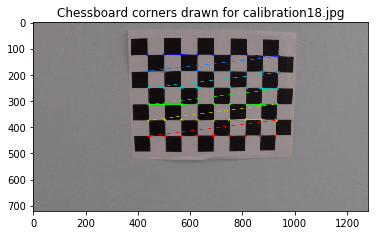

In [3]:
# Invoke Camera Caliberator and caliberate using input images 
cc = CameraCalibrator("camera_cal", (9,6))

# Caliberate method will randomly output the chessboard corners 
# visualization for any one of the images used in calibration
cc.calibrate();


## Undistort sample images 
CameraCaliberator class's undistort image is used to undistort any input image. The code below, uses one of the images in "camera_cal" folder and undistorts them 

In [4]:
import cv2
sample_image_for_undistortion = "camera_cal\\calibration1.jpg"
image = cv2.imread(sample_image_for_undistortion)
undistorted_image = cc.undistort(image)

### Example of distortion corrected image 


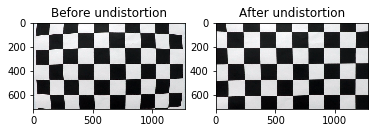

In [5]:
# Plot the before and after undistortion images 

fig, axes = plt.subplots(1, 2)
ax = plt.subplot(1, 2, 1)
ax.set_title("Before undistortion")
ax.imshow(image)

ax = plt.subplot(1, 2, 2)
ax.imshow(undistorted_image)
ax.set_title("After undistortion")

plt.show()


### (Optional) Save the Camera Calibration Parameters 

In [6]:
import pickle 

'''Optional - Save Pickle File containing camera calibration parameters'''
# Cache away the camera caliberation data 
data = {'CameraCalibrator': cc};
pickle_file_name = "camera_calibration.p";
pickle.dump(data, open(pickle_file_name, "wb"))

----

## 2. Pipeline (test images)


### (Optional) Load the Camera Calibration Parameters

In [7]:

pickle_file_name = "camera_calibration.p"
data = pickle.load(open(pickle_file_name, "rb"));
cc = data["CameraCalibrator"]

### Define Lane Detection Pipeline

In [8]:
# Define a Lane class to receive the characteristics of each lane identified
import numpy as np
class Lane():
    def __init__(self, fit, fitx, ploty, isLeft):
        self.isLeft  = isLeft
        self.fit = fit
        self.fitx = fitx 
        self.ploty = ploty
        self.curvature = None
        self.offset = None
        self.offset_direction = None

In [9]:
# Define a LaneStatistics class to store the best known statistics of all lanes detected across frames
import numpy as np
class LaneStatistics():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        
        # last 7 fits
        self.last_n_index  = 0
        
        self.last_n_fit = [None]*7
        
        # plotys stored 
        self.ploty = None 
        
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
        #x values for detected line pixels
        self.allx = None  
        
        #y values for detected line pixels
        self.ally = None

In [10]:
class LanesInPerspectiveTransform():
    def __init__(self, left_lane_inds, right_lane_inds, nonzero_x, nonzero_y):
        self.left_lane_inds = left_lane_inds
        self.right_lane_inds = right_lane_inds
        self.nonzero_x = nonzero_x
        self.nonzero_y = nonzero_y

In [11]:
# Define a LaneDetector class which given a warped_image after pespective transform can identify lane lines 
class LaneDetector():
    # Constructor
    def __init__(self):
        self.image = None
        self.out_file_name = None
    
        # Number of frames 
        self.frame_count = 0
        
        # Number of frames in left_line 
        self.nframes_left_lane_statistics = LaneStatistics()
        
        # Number of frames in right line 
        self.nframes_right_lane_statistics = LaneStatistics()
        
        # last known good left fit line/lanes 
        self.prev_left_fit = []
        
        # last known good right fit line/lanes 
        self.prev_right_fit = []
        
    # Setters for image and output file names 
    def set_image(self, image):
        self.image = image
    
    def set_output_file(self, file_name):
        self.out_file_name = file_name
    
    ''' detect_and_add_lanees - detects lanes using sub / helper functions, draws them on the input image and also
    finds the radius of curvature and lane offset from the center of image 
    # Input Args
    ## warped_image - image obtained after a prespective transform
    ## file_name - file name in which the embedding of lanes on the image need to be written out 
    '''
    def detect_and_add_lanes(self, processing_for_video=False):
        left_lane = None
        right_lane = None 
        mean_curvature = None
        
        warped_image = self.image
        file_name =  self.out_file_name
        
        # Find left and right lane fits 
        success, left_lane, right_lane = self.find_lane_fits(warped_image, file_name, processing_for_video );
        #print("Outside lane_fit ", self.frame_count)
        
        if left_lane is not None and right_lane is not None:
            # print("Inside lane_fit ", self.frame_count)
            # Find radius of curvature using ploty 
            left_lane.curvature = self.compute_radius_of_curvature(left_lane) 
            right_lane.curvature = self.compute_radius_of_curvature(left_lane)
            
            # Compute mean curvature 
            mean_curvature = np.mean([left_lane.curvature, right_lane.curvature])/1000.0;

            # Compute lane offset from the center of the x axis 
            left_lane.offset, left_lane.offset_direction = self.compute_lane_offset(left_lane, right_lane, warped_image.shape[1]/2)
            right_lane.offset, right_lane.offset_direction = left_lane.offset, left_lane.offset_direction
            
            if success:
                # Add line statistics 
                self.add_line_statistics(left_lane, isLeftLane=True)
                self.prev_left_fit = left_lane.fit
            
                self.add_line_statistics(right_lane, isLeftLane=False)
                self.prev_right_fit = right_lane.fit

         # Increment frame count while using this image to process video streams
        self.frame_count+=1
        return left_lane, right_lane, mean_curvature

    '''find_lane_fits - functions finds the left and right lane fits along with the y positions along which the lane fit 
    centroids are found. This method uses the sliding window method in the bottom half of the image for finding lanes for the 
    FIRST FRAME ONLY. There after, it tries to pick the lane fits within the identified sliding windows 
    # Input Args
    ## warped_image - image obtained after a perspective transform
    ## file_name - file name in which the embedding of the lanes on the image need to be written out 
    '''
    def find_lane_fits(self, warped_image, file_name, processing_for_video=False):
        use_sliding_windows = True
        #if self.frame_count == 0 or processing_for_video == False:
        #    use_sliding_windows = True
        '''
        print("Frame Count =", self.frame_count)
        print("Processing of video = ", processing_for_video)
        print("Use sliding windows = ", use_sliding_windows)
        '''
        
        success, left_lane, right_lane = self.find_lanes(warped_image, file_name, use_sliding_windows);
        
        return success, left_lane, right_lane
   
    ''' find_lanes = core algorithm which finds lanes in an image 
    # Input Args
    # image - input in which lanes need to be detected 
    # out_file_name - file name to be used where image with lanes will be drawn 
    # number_of_sliding_windows - number of windows to use to find the find the lanes 
    # margin - margin / padding to be added to each window for finding lanes 
    # min_qual_pixels - minimum number of pixels required to get a candidate lane 
    # plot_* - switches to enable visualization of histogram / lane fits 
    '''
    def find_lanes(self, image, out_file_name, use_sliding_windows, number_sliding_windows=9):
        success = True
        left_lane = None
        right_lane = None
        
        # Identify all nonzero pixels of the image
        nonzero = image.nonzero()
        nonzero_y = np.array(nonzero[0])
        nonzero_x = np.array(nonzero[1])

        # Set width of windows +/- margin
        margin = 100
        
        out_img = None
        if use_sliding_windows == True:
            # Slide windows over the image from bottom to top to get the line fit
            out_img, left_lane_inds, right_lane_inds = self.slide_windows(image, number_sliding_windows, nonzero_x, nonzero_y);
            lanes_in_pt = LanesInPerspectiveTransform(left_lane_inds, right_lane_inds, nonzero_x, nonzero_y);
            lanes_in_pt = self.post_process_lane_inds(image, out_img, lanes_in_pt)
        else:
            # Use previous fits to detect good lane indices
            prev_left_fit = self.prev_left_fit
            prev_right_fit = self.prev_right_fit
            left_lane_inds = ((nonzero_x > (prev_left_fit[0]*(nonzero_y**2) + prev_left_fit[1]*nonzero_y + prev_left_fit[2] - margin)) & (nonzero_x < (prev_left_fit[0]*(nonzero_y**2) + prev_left_fit[1]*nonzero_y + prev_left_fit[2] + margin))) 
            right_lane_inds = ((nonzero_x > (prev_right_fit[0]*(nonzero_y**2) + prev_right_fit[1]*nonzero_y + prev_right_fit[2] - margin)) & (nonzero_x < (prev_right_fit[0]*(nonzero_y**2) + prev_right_fit[1]*nonzero_y + prev_right_fit[2] + margin)))  

        # Fit a polynomial line using the indices found
        try:
            # once the candidates of line indices are obtained, fit a polynomial
            left_fit = self.fit_lane_line(left_lane_inds, nonzero_x, nonzero_y)
        except ValueError:
            # If line fit fails, resolve to the previous known best fit 
            left_fit = self.prev_left_fit
        except TypeError:
            # If line fit fails, resolve to the previous known best fit 
            #left_fit = self.prev_left_fit
            #last_n_fits = self.nframes_left_lane_statistics.last_n_fit
            #left_fit = [np.mean(last_n_fits[0]), np.mean(last_n_fits[1]), np.mean(last_n_fits[2])]
            left_fit = self.nframes_left_lane_statistics.best_fit
            ploty = self.nframes_left_lane_statistics.ploty
            success = False
        
        try:
            # once the candidates of line indices are obtained, fit a polynomial
            right_fit = self.fit_lane_line(right_lane_inds, nonzero_x, nonzero_y)
        except ValueError:
            # If line fit fails, resolve to the previous known best fit 
            right_fit = np.mean([])
        except TypeError:
            # If line fit fails, resolve to the previous known best fit 
            #right_fit = self.prev_right_fit
            # last_n_fits = self.nframes_left_lane_statistics.last_n_fit
            # right_fit = [np.mean(last_n_fits[0]), np.mean(last_n_fits[1]), np.mean(last_n_fits[2])]
            right_fit = self.nframes_right_lane_statistics.best_fit
            ploty = self.nframes_right_lane_statistics.ploty
            success = False
            
        # Compute the visualization elements of the lane 
        if success == True:
            ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
            
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        left_lane = Lane(left_fit, left_fitx, ploty, isLeft=True);
        right_lane = Lane(right_fit, right_fitx, ploty, isLeft=False);

        return success, left_lane, right_lane
    ''' slide_windows - method slides windows from left to right in the lower half of the image to identify
    pixel indices where lanes can be found
    '''
    def slide_windows(self, image, number_sliding_windows, nonzero_x, nonzero_y):
        nwindows = number_sliding_windows
        window_height = np.int(image.shape[0]/nwindows)

        leftx_current, rightx_current = self.get_x_base_for_lanes(image)

        margin=100
        min_qual_pixels=50
        
        # Create an output image to draw on and  visualize the result
        sliding_window_image = np.dstack((image, image, image))*255
        left_lane_inds = []
        right_lane_inds = []
        for window in range(nwindows):
            # identify window boundaries x, y , right and left 
            l_low, l_high, r_low, r_high, y_low, y_high = self.compute_margins(image.shape[0], window_height, window, margin, leftx_current, rightx_current);
            
            # Draw the windows on the visualization image
            sliding_window_image = cv2.rectangle(sliding_window_image,(l_low,y_low),(l_high,y_high),(0,255,0), 6) 
            sliding_window_image = cv2.rectangle(sliding_window_image,(r_low,y_low),(r_high,y_high),(0,255,0), 6) 

            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzero_y >= y_low) & (nonzero_y < y_high) & (nonzero_x >= l_low) & (nonzero_x < l_high)).nonzero()[0]
            good_right_inds = ((nonzero_y >= y_low) & (nonzero_y < y_high) & (nonzero_x >= r_low) & (nonzero_x < r_high)).nonzero()[0]

            
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > min_qual_pixels:
                leftx_current = np.int(np.mean(nonzero_x[good_left_inds]))
            if len(good_right_inds) > min_qual_pixels:        
                rightx_current = np.int(np.mean(nonzero_x[good_right_inds]))
            
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        return sliding_window_image, left_lane_inds, right_lane_inds
    def post_process_lane_inds(self, image, out_img, lanes_in_pt):
        if self.frame_count == 13:
            n_left_inds = len(lanes_in_pt.left_lane_inds)
            n_right_inds = len(lanes_in_pt.right_lane_inds)
            
            if n_right_inds <= (0.01* n_left_inds):
                lanes_in_pt = self.add_lane_inds(image, lanes_in_pt, copy_from_left_to_right=True)
            elif n_left_inds <= (0.01* n_right_inds):
                lanes_in_pt = self.add_lane_inds(image, lanes_in_pt, copy_from_left_to_right=False)

            # Visualize images
            out_img_sw = np.copy(out_img)
            out_img_sw[lanes_in_pt.nonzero_y[lanes_in_pt.left_lane_inds], lanes_in_nonzero_x[left_lane_inds]] = [255, 0, 0]
            out_img_sw[lanes_in_pt.nonzero_y[lanes_in_pt.right_lane_inds], nonzero_x[right_lane_inds]] = [0, 0, 255]
            mpimg.imsave("test_videos_output//sample_" + str(self.frame_count) + "_slidingwindows.png" , out_img_sw);
        return lanes_in_pt
    def add_lane_inds(self, image, lanes_in_pt, copy_from_left_to_right=True):
        reference_lane_inds = lanes_in_pt.left_lane_inds
        to_copy_inds = lanes_in_pt.right_lane_inds
        if copy_from_left_to_right==False:
            reference_lane_inds = lanes_in_pt.right_lane_inds
            to_copy_inds = lanes_in_pt.left_lane_inds
            
        binary_image = np.zeros_like(image)
        
        # beef up right lane indices 
        sorted_inds = sorted(reference_lane_inds, reverse=True)
        for ind in sorted_inds:
            x,y = lanes_in_pt.nonzero_x[ind], lanes_in_pt.nonzero_y[ind]
            new_x = int(np.mean(lanes_in_pt.nonzero_x[to_copy_inds]))
            binary_image[y, new_x] = 1
        nonzero = binary_image.nonzero()
        new_nonzero_x = nonzero[1]
        new_nonzero_y = nonzero[0]
        
        #nonzero_x = nonzero_x | new_nonzero_x
        #nonzero_y = nonzero_y | new_nonzero_y
        
        #new_right_lane_inds =  ((nonzero_y >= y-10) & (nonzero_y < y+10) & (nonzero_x >= new_x-10) & (nonzero_x < new_x+10)).nonzero()[0]
        #right_lane_inds = np.concatenate(right_lane_inds.append(new_right_lane_inds))
        return lanes_in_pt
    ''' get_x_base_for_lanes - method computes the set of pixels of interest in x dimension to locate left lane and right lane respectively
    '''
    def get_x_base_for_lanes(self, image):
         # Compute histogram of image in the lower half of the image for values in the x axis 
        histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        
        return leftx_base, rightx_base
   
    ''' compute_margins - method helps in computing the padded window dimensions given a leftx and right x position along 
    with a margin width 
    '''
    def compute_margins(self, total_height, window_height, window_id, margin, leftx_current, rightx_current):
        y_low = total_height - (window_id + 1) * window_height
        y_high = total_height - window_id * window_height
        xleft_low = leftx_current - margin
        xleft_high = leftx_current + margin
        xright_low = rightx_current - margin
        xright_high = rightx_current + margin
        return xleft_low, xleft_high, xright_low, xright_high, y_low, y_high
    '''fit_lane_line - method uses the left and right lane indices along with nonzero_x and y to get a polynomial line fit 
    '''
    def fit_lane_line(self, lane_inds, nonzero_x, nonzero_y):
        # Extract left and right line pixel positions
        x = nonzero_x[lane_inds]
        y = nonzero_y[lane_inds] 
        
        # Fit a second order polynomial to each
        fit = np.polyfit(y, x, 2)
        return fit
    
    ''' compute_radius_of_curvature - method helps compute the radius of curvature of a line given ploty, left fit and right fit
    '''
    def compute_radius_of_curvature(self, lane):
        #Define y-value where we want radius of curvature
        # I'll choose the maximum y-value, corresponding to the bottom of the image
        y_eval = np.max(lane.ploty)

        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        fit_cr = np.polyfit(lane.ploty*ym_per_pix, lane.fitx*xm_per_pix, 2)
        
        # Calculate the new radii of curvature
        curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
        
        return curverad

    ''' compute_lane_offset - function finds the offset of left and right lanes given the midpoint of the image
    and its direction of offset(left or right)
    # Input Args 
    # left_fitx - left fit lane's x values
    # right_fitx - right fit lanes' x values 
    # midpoint - mid point of the image 
    '''
    def compute_lane_offset(self, left_lane, right_lane, midpoint):
        # find the lane width
        left_fitx = left_lane.fitx
        right_fitx = right_lane.fitx
        
        lane_width = np.absolute(left_fitx[0] - right_fitx[0])
        
        # find the lane center wrt width of the lane 
        lane_center = left_fitx[0] + (lane_width/2)
        
        # find the offset of lanes from the mid point of the image 
        offset = lane_center - midpoint
        
        # Do a conversion from pixels to meters 
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        offset_in_meters = offset*xm_per_pix
        
        # If offset is < 0 then the lane center is skewed to the right 
        # otherwise the lane center is to the left of the midpoint of the image
        offset_direction = "left";
        if offset < 0:
            offset_direction = "right"
        
        # return offset and offset direction
        return offset_in_meters, offset_direction
    ''' add_line_statistics - analyzes the current fit and previous fit along with other statistical information
    like offset, offset direction and updates them for each frame
    # Input Args
    # line             - line object to which the statistics needs to be added 
    # fit              - line fit found for a given image (left / right fit)
    # prev_fit         - previously known fit 
    # fitx             - x values involved in the fit 
    # ploty            - y values used for plotting the fit 
    # curvature        - radius of curvature observe for the line fit 
    # offset           - line offset from the middle of the image 
    # offset_direction - offset direction
    '''
    def add_line_statistics(self, lane, isLeftLane):
        if isLeftLane==True:
            lane_statistics = self.nframes_left_lane_statistics
            prev_fit = self.prev_left_fit
        else:
            lane_statistics = self.nframes_right_lane_statistics
            prev_fit = self.prev_right_fit
        
        
        # was the line detected in the last iteration?
        lane_statistics.detected = True
        
        # x values of the last n fits of the line
        lane_statistics.recent_xfitted = lane.fitx
        
        #average x values of the fitted line over the last n iterations
        if lane_statistics.bestx is not None:
            lane_statistics.bestx = np.mean([np.mean(lane.fitx), lane_statistics.bestx/self.frame_count])     
        else:
            lane_statistics.bestx = np.mean(lane.fitx)
        
        # last 7 fits
        lane_statistics.last_n_index  +=1 
        if lane_statistics.last_n_index == 7:
            lane_statistics.last_n_index = 0;
        
        lane_statistics.last_n_fit[lane_statistics.last_n_index] = lane.fit
        
        # plotys
        lane_statistics.ploty = lane.ploty
        
        #polynomial coefficients averaged over the last n iterations
        if lane_statistics.best_fit is not None:
            lane_statistics.best_fit = [(lane_statistics.best_fit[0] + (lane.fit[0]*5))/6, (lane_statistics.best_fit[1] + (lane.fit[1]*5))/6, (lane_statistics.best_fit[2] + (lane.fit[2]*5))/6]
        else:
            lane_statistics.best_fit = lane.fit
            
        
        #polynomial coefficients for the most recent fit
        lane_statistics.current_fit = lane.fit
        
        #radius of curvature of the line in some units
        lane_statistics.radius_of_curvature = lane.curvature
        
        #distance in meters of vehicle center from the line
        lane_statistics.offset = lane.offset
        lane_statistics.offset_direction = lane.offset_direction
        
        #difference in fit coefficients between last and new fits
        if prev_fit is not None and lane.fit is not None and len(prev_fit) == 3:
            '''
            print ("Inside lane statistics ... ")
            print(len(prev_fit))
            print(len(lane.fit))
            print(prev_fit)
            print(lane.fit)
            '''
            lane_statistics.diffs = np.array(prev_fit) - np.array(lane.fit)
            
            
        #x values for detected line pixels
        lane_statistics.allx = lane.fitx  
        #y values for detected line pixels
        lane_statistics.ally = lane.ploty
   
    
   
    

In [12]:
# cv2
import cv2

# os, sys for iterating over files in folders
import os, sys

# 
import numpy as np

# for copying image and save them to disk 
import matplotlib.image as mpimg

import matplotlib.pyplot as plt


In [13]:
''' Lane Detection Pipeline 
This class defines the pipeline required for detecting lanes in an image 
'''
class LaneDetectionPipeline:
    ''' Constructor 
    # Input args
    ## CameraCaliberation - cameraCaliberator object which has the required distortion matrix to undistort images 
    ## root_folder        - where input images are present
    ## output_folder      - where output images with lane detected and painted are output
    '''
    def __init__(self, cameraCalibration, root_folder, output_folder):
        # root folder 
        self.root_folder = root_folder
        
        # output folder 
        self.output_folder = output_folder
        
        # Camera Caliberation object 
        self.cameraCalibration = cameraCalibration
        
        # Lane Detector object
        self.laneDetector = LaneDetector();
        
        self.frame_count = 0

    ''' Execute method 
    1. Reads all images from the root / input folder 
    2. Invokes process_image method for each image in the folder 
    '''
    def execute(self):
        print ("Starting pipeline for lane detection... ")
        # Loop through all images in the root_folders
        file_list = os.listdir(self.root_folder)
        for file in file_list:
            print("Image: " + file)
            # read image
            image = cv2.imread(self.root_folder+"/"+ file)
            
            output_image  = self.process_image(image, file, processing_for_video=False);
            
            if output_image is not None:
                fig = plt.figure();
                plt.imshow(output_image)
                plt.show()
            

    ''' imsave - Helper method to save intermediate results of pipeline 
    '''
    def imsave(self, image, file_name, suffix_name, isgray=False):
        if isgray == True:
            mpimg.imsave(self.output_folder + "/" + file_name +"_" + str(self.frame_count) + "_" + suffix_name + ".png" , image, cmap="gray");
        else:
            mpimg.imsave(self.output_folder + "/" + file_name +"_" + str(self.frame_count) + "_" + suffix_name + ".png" , image);

        
    ''' Process Image method defines the key pipeline required to detect lanes in an image
    # Input args:
    ## image - actual image 
    ## file - file name (prefix which can be used to output intermediate images after each stage of the pipeline
    '''
    def process_image(self, image, file="sample", processing_for_video=True):
        # extract the file name 
        file_parts  = file.split(".")
        
        ''' Lane Detection Pipeline 
        1. Undistort Image 
        2. Apply color threshold 
        3. Apply gradient threshold 
        4. Compute perspective matrix 
        5. Detect And Add Lanes 
        '''
        ## 1. Undistort Image 
        # Use camera caliberator to undistort image
        image = self.cameraCalibration.undistort(image);
        #self.imsave(image, file_parts[0], "Undistorted")
        
        color_binary = self.apply_color_threshold(image)
        #self.imsave(image, file_parts[0], "ColorBinary", True)
        
        mag_sobel_binary, direction_binary, sobelx_binary, sobely_binary = self.apply_gradient_threshold(color_binary)

        # Combine the two binary thresholds
        combined_binary = np.zeros_like(color_binary)
        combined_binary[(mag_sobel_binary == 1) & (direction_binary == 1) & (sobelx_binary == 1)] = 1
        
        # Combine the two binary thresholds
        #combined_binary[(yellow_binary == 255)] = 1
        # self.imsave(combined_binary, file_parts[0], "Out", True)
        
        #mask = self.binary_noise_reduction(combined_binary, 4)

        # Compute perspective matrices
        M, Minv = self.compute_perspective_matrix(combined_binary);

        # Compute warped image
        warped_image = self.apply_perspective(M, combined_binary)
        # self.imsave(warped_image, file_parts[0], "Warped", True)
        
        if processing_for_video == True:
            self.imsave(image, file_parts[0], "Original")
            self.imsave(color_binary, file_parts[0], "ColorBinary", isgray=True)
            # self.imsave(yellow_binary, file_parts[0], "YellowBinary" , isgray=True)
            self.imsave(combined_binary, file_parts[0], "GradientBinary", isgray=True)
            # self.imsave(mask, file_parts[0], "Mask", isgray=True)
            self.imsave(warped_image, file_parts[0], "Warped")
        # Detect Lanes
        self.laneDetector.set_image(warped_image)
        self.laneDetector.set_output_file(file_parts[0])
        
        left_lane, right_lane, mean_curvature = self.laneDetector.detect_and_add_lanes(processing_for_video);
        
        # Generate output image 
        output_image = self.generate_output(image, warped_image, Minv, left_lane, right_lane, mean_curvature)
        
        if processing_for_video == True:
            self.imsave(output_image, file_parts[0], "Output")

        self.frame_count += 1
        # self.imsave(output_image, file_parts[0], "FinalOutput")
       
        return output_image
    def extract_yellow(self, img):
        """
        generate an image mask selecting yellow pixels.
        :param img: image with pixels in range 0-255
        :return: Yellow 255 not yellow 0
        """
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        mask = cv2.inRange(hsv, (20, 50, 150), (40, 255, 255))
        return mask

    def extract_highlights(self, img, p=99.9):
        """
        generate an image mask selecting highlights.
        :param p: percentile for highlight selection. default=99.9
        :param img: image with pixels in range 0-255
        :return: Highlight 255 not highlight 0
        """
        p = int(np.percentile(img, p) - 30)
        mask = cv2.inRange(img, p, 255)
        return mask
    def binary_noise_reduction(self, img, thresh):
        """
        reduce noise of a binary image by applying a filter which counts neighbors with a value
        and only keeping those which are above the threshold.
        :param img: binary image (0 or 1)
        :param thresh: min number of neighbors with value
        :return:
        """
        k = np.array([[1, 1, 1],
                      [1, 0, 1],
                      [1, 1, 1]])
        nb_neighbors = cv2.filter2D(img, ddepth=-1, kernel=k)
        img[nb_neighbors < thresh] = 0
        return img
    ''' apply_color_threshold  - function converts an input image to another colorspace (HLS / HSV) 
    and applies the min and max threshold on the values of the appropriate channel 
    # Input Args
    ## image = image to be converted to the new color space
    ## color_space = colorspace to which image needs be to converted to
    ## thresh_channel = Channel index on which thresholding needs to be applied
    ## thresh = tuple consisting of lower and upper threshold limits 
    '''
    def apply_color_threshold(self, image, color_space="HLS", thresh_channel=2, thresh=(100, 255)):
        image_in_colorspace = [];
        if color_space == "HLS":
            image_in_colorspace = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == "HSV":
            image_in_colorspace = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        else:
            image_in_colorspace = np.copy(image)

        image_in_colorspace[:, :, 1] = 1
        image2 = cv2.cvtColor(image_in_colorspace, cv2.COLOR_HLS2RGB)
        image_in_colorspace = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        
        #thresh = (0.23, 1)
        thresholding_channel = image_in_colorspace[:, :, thresh_channel]
        
        # Create a binary mask where the thresholding is applied
        color_binary = np.zeros_like(thresholding_channel)
        color_binary[(thresholding_channel >= thresh[0]) & (thresholding_channel <= thresh[1])] = 1

        # Cache away as object's member variable
        self.image_in_colorspace = thresholding_channel
        
        # return color_binary_mask
        return color_binary

    ''' apply_gradient_threshold - function computes sobel x and sobel y gradient and applies the respective thresholds 
    # Input Args
    ## image = image to be converted to the new color space
    ## abs_thresh = tuple consiting of lower and upper threshold limits for absolute value of sobel gradient
    ## direction_thresh = tuple consiting of lower and upper threshold limits for direction of sobel gradient
    '''
    # 20, 100 0.7, 1.3
    def apply_gradient_threshold(self, image, sobel_thresh=(25, 100), abs_thresh=(20, 100), mag_threshold=(1, 4), direction_thresh=(0.4, 1)):
        # Apply gradient transform only to lower half of the image
        imshape = image.shape
        vertices = np.array([[(200, imshape[0]), (450,320), (490,320), (imshape[1], imshape[0])]])
        
        mask = np.zeros_like(image)
        ignore_mask_color=255
        cv2.fillPoly(mask, vertices, 255)
        image_copy = cv2.bitwise_and(image, mask)
        
        
        # Compute sobel x, y gradient 
        scaled_sobel_x, abs_sobel_x = self.get_scaled_sobel(image_copy, orient="x")
        scaled_sobel_y, abs_sobel_y = self.get_scaled_sobel(image_copy, orient="y")
        
        magnitude = np.sqrt(abs_sobel_x**2 + abs_sobel_y**2)
        
        # Apply thresholds for the magnitude
        mag_sobel_binary = np.zeros_like(magnitude)
        mag_sobel_binary[(magnitude >= mag_threshold[0]) & (magnitude <= mag_threshold[1])] = 1

        # Apply thresholds for the direction 
        direction_gradient = np.arctan2(scaled_sobel_y, scaled_sobel_x)
        direction_binary = np.zeros_like(direction_gradient)
        direction_binary[(direction_gradient > direction_thresh[0]) & (direction_gradient <= direction_thresh[1])] = 1
        
        sobelx_binary = np.zeros_like(scaled_sobel_x)
        sobelx_binary[(scaled_sobel_x >= sobel_thresh[0]) & (scaled_sobel_x <= sobel_thresh[1])] = 1
        
        sobely_binary = np.zeros_like(scaled_sobel_y)
        sobely_binary[(scaled_sobel_y >= sobel_thresh[0]) & (scaled_sobel_y <= sobel_thresh[0])] = 1
        
        # return the magnitude and direction binary mask 
        return mag_sobel_binary, direction_binary, sobelx_binary, sobely_binary
    ''' compute_perspective_matrix - inputs image and computes the perspective transform 
    # Input Args
    # image - input image to be transformed
    '''
    def compute_perspective_matrix(self, image):
        # Take image shape 
        image_shape = image.shape;
        
        # compute width and height 
        w = image_shape[1];
        h = image_shape[0];
        
        #offset = 200;
        #src = np.float32([[210, h-20], [w/2 - 40, h/2 + 90 ], [w/2 + 40 , h/2 + 90],[1070, h-20]])
        #dst = np.float32([[210+offset, h-20], [210+offset, 0 ], [1070- offset , 0],[1070-offset, h-20]])
        
        # Create a ball park of src and destination points 
        src = np.float32([ [200,720],[600,450],[1150,720],[700,450]])
        dst = np.float32([ [350,720],[350,0],  [1000,720],[1000,0]])
        '''
        offset = 250
        src = np.float32([
                    (132, 703),
                    (540, 466),
                    (740, 466),
                    (1147, 703)])

        dst = np.float32([
                    (src[0][0] + offset, 720),
                    (src[0][0] + offset, 0),
                    (src[-1][0] - offset, 0),
                    (src[-1][0] - offset, 720)])
        '''
        # Use the mapping to create a perspective transform 
        M = cv2.getPerspectiveTransform(src, dst)
        
        # Use the mapping to get inverse perspective transform
        Minv = cv2.getPerspectiveTransform(dst, src)
        
        return M, Minv

    ''' apply_perspective - uses a perspective transform matrix and applies into image 
    # Input Args 
    # image - image to be transformed 
    # M - perspective transform matrix 
    '''
    def apply_perspective(self, M, image):
        img_size = (image.shape[1], image.shape[0])
        warped_image = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
        return warped_image

   
    ''' apply_color_mask - method to apply color mask given a low and high threshold 
    
    '''
    def apply_color_mask(self, image, low_threshold, high_threshold):
        binaries = [];
        h,l,s = cv2.split(image)
        binary = np.zeros_like(h)
        binary[(h >= low_threshold[0]) & (h <= high_threshold[0]) & (l >= low_threshold[1]) & (l <= high_threshold[1]) & (s >= low_threshold[2]) & (s <= high_threshold[2])] = 1
        mpimg.imsave(self.output_folder + "/sample_colormask.png" , binary, cmap="gray");
        return binary
    ''' get_scaled_sobel - scales the sobel val between 0 and 1 depending upon the orientation of the gradient 
    '''
    def get_scaled_sobel(self, image, orient="x"):
        sobel_val = [];
        if orient == "x":
            sobel_val = cv2.Sobel(image, cv2.CV_64F, 1, 0)
        elif orient == "y":
            sobel_val = cv2.Sobel(image, cv2.CV_64F, 0, 1)
        abs_sobel = np.absolute(sobel_val)
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        return scaled_sobel, abs_sobel
     
    ''' generate_output - method generates the output image with annotated radius of curvature and offset directions 
    # Input Args
    # original_image
    # warped_image
    # Minv - inverse perspective matrix
    # left_fitx
    # right_fitx
    # ploty 
    # curvature
    # offset
    # offset_direction
    '''
    def generate_output(self, original_image, warped_image, Minv, left_lane, right_lane, curvature):
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped_image).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        result_image = np.copy(original_image)
        # Recast the x and y points into usable format for cv2.fillPoly()
        if left_lane is not None and right_lane is not None:
            pts_left = np.array([np.transpose(np.vstack([left_lane.fitx, left_lane.ploty]))])
            pts_right = np.array([np.flipud(np.transpose(np.vstack([right_lane.fitx, right_lane.ploty])))])
            pts = np.hstack((pts_left, pts_right))

            # Draw the lane onto the warped blank image
            cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

            # Warp the blank back to original image space using inverse perspective matrix (Minv)
            newwarp = cv2.warpPerspective(color_warp, Minv, (warped_image.shape[1], warped_image.shape[0])) 

            # Combine the result with the original image
            result_image = cv2.addWeighted(original_image, 1, newwarp, 0.3, 0)

            # Write details on radius of curvature and lane center offset
            font_face = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 1
            font_color = (255, 255, 255)
            result_image = cv2.putText(result_image,"Radius of Curvature = " + str(curvature) + " km", (0, 50), font_face, font_scale, font_color)
            result_image = cv2.putText(result_image,"Vehicle is " + str(np.absolute(left_lane.offset)) + " m " + left_lane.offset_direction +  " of center", (0, 100), font_face, font_scale, font_color)
        return result_image
   


### Executing Pipeline on Test Images

Starting pipeline for lane detection... 
Image: straight_lines1.jpg


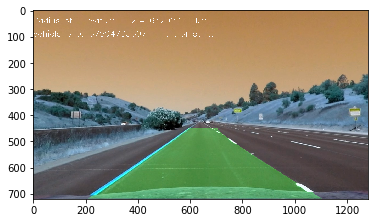

Image: straight_lines2.jpg


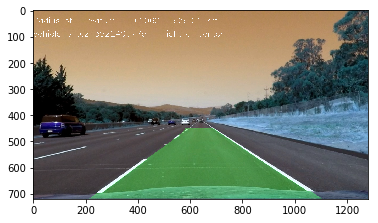

Image: test1.jpg


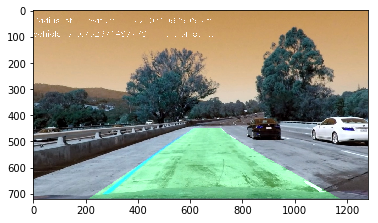

Image: test2.jpg


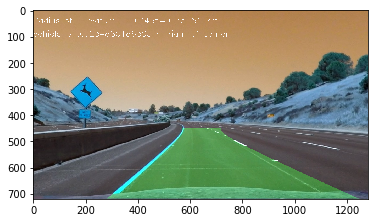

Image: test3.jpg


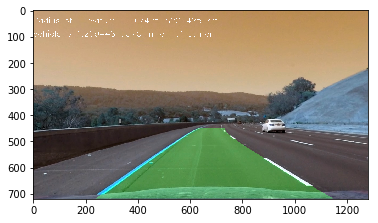

Image: test4.jpg


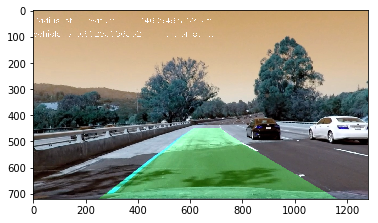

Image: test5.jpg


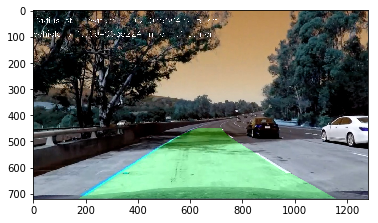

Image: test6.jpg


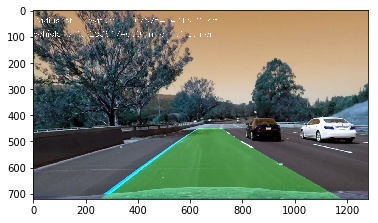

In [14]:
root_folder = "test_images"
ldp = LaneDetectionPipeline(cc, root_folder, "test_images_output");
ldp.execute()

## 3. Pipeline (Video)

In [15]:
# for video to image utils 
from moviepy.editor import VideoFileClip
import imageio
imageio.plugins.ffmpeg.download()


In [16]:
test_output = 'test_videos_output\\project_video.mp4'
clip2 = VideoFileClip('test_videos\\project_video.mp4')

output_folder = "test_videos_output"
ldp = LaneDetectionPipeline(cc, "test_videos", output_folder);
pclip = clip2.fl_image(ldp.process_image).subclip(24,27)
pclip.write_videofile(test_output, audio=False)


[MoviePy] >>>> Building video test_videos_output\project_video.mp4
[MoviePy] Writing video test_videos_output\project_video.mp4


 14%|███████████▊                                                                      | 11/76 [00:08<00:49,  1.30it/s]

NameError: name 'nonzero_y' is not defined

## 4. Pipeline (Challenge Video)

In [18]:
test_output = 'test_videos_output\\challenge_video.mp4'
clip2 = VideoFileClip('test_videos\\challenge_video.mp4')

output_folder = "test_videos_output"
ldp = LaneDetectionPipeline(cc, "test_videos", output_folder);
pclip = clip2.fl_image(ldp.process_image).subclip(0, 5)
pclip.write_videofile(test_output, audio=False)


IndexError: list index out of range